<a href="https://colab.research.google.com/github/rndrpp/Fish-Productions-Clustering/blob/main/Fish_Productions_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To-Do List

**Objective**: Help developing the best unsupervised model for future fishing production insight.

**To-do**:

**EDA is not needed**

**Data Preprocessing**

*Cleaning*
- Fill missing values if any
- Drop duplicates if any
*Encoding*
- Encode categorical data
*Scaling*
- Scaling to normalize the data

**Modelling Algorithm**
- We'll try Agglomerative, BIRCH, or GMM

**Cluster Visualization**
- Use PCA to visualize the clustering result

**Finalized Model**
- Save the model to use it later

**Post Processing**
- Define suitable label for the labeling result

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import scipy.cluster.hierarchy as shc
import pickle

sns.set_theme(style="darkgrid")
sns.set_palette("tab10")

# Import Dataset

In [ ]:
df_og = pd.read_hdf('/content/drive/MyDrive/Data_20220926.h5')

df_og.head()

,Jenis Usaha,Provinsi,Jenis Ikan,Tahun,Volume Produksi,Nilai Produksi
0,BUDIDAYA,BANTEN,BANDENG,2010,11071.00,82781877.0
1,BUDIDAYA,BANTEN,BANDENG,2011,9542.74,124055620.0
2,BUDIDAYA,BANTEN,BANDENG,2012,8739.46,239161200.0
3,BUDIDAYA,BANTEN,BANDENG,2013,10997.10,171425024.0
4,BUDIDAYA,BANTEN,BANDENG,2014,11141.62,174132000.0


In [ ]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4191 entries, 0 to 4190
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Jenis Usaha      4191 non-null   object 
 1   Provinsi         4191 non-null   object 
 2   Jenis Ikan       4191 non-null   object 
 3   Tahun            4191 non-null   int64  
 4   Volume Produksi  4191 non-null   float64
 5   Nilai Produksi   4191 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 229.2+ KB


In [ ]:
df_og.describe()

,Tahun,Volume Produksi,Nilai Produksi
count,4191.000000,4191.000000,4.191000e+03
mean,2016.303508,11328.691842,1.979619e+08
std,3.692020,43858.337896,7.160106e+08
min,2010.000000,0.000000,0.000000e+00
25%,2013.000000,30.970000,6.552000e+02
50%,2016.000000,469.310000,9.273500e+06
75%,2020.000000,4028.190000,7.997198e+07
max,2021.000000,699235.920000,1.350065e+10


Volume Produksi and Nilai Produksi are skewed so we'll see outliers on our clusters

In [ ]:
cats = df_og.select_dtypes(include='object').columns.tolist()
for cat in cats:
    print(f'{cat} total unique value: {df_og[cat].nunique()}')
    print(f'{cat} values: {df_og[cat].unique().tolist()} ', '\n')

Jenis Usaha total unique value: 3
Jenis Usaha values: ['BUDIDAYA', 'TANGKAP LAUT', 'TANGKAP PUD']  

Provinsi total unique value: 6
Provinsi values: ['BANTEN', 'DAERAH ISTIMEWA YOGYAKARTA', 'DKI JAKARTA', 'JAWA BARAT', 'JAWA TENGAH', 'JAWA TIMUR']  

Jenis Ikan total unique value: 132
Jenis Ikan values: ['BANDENG', 'BAWAL', 'BELANAK', 'GURAMI', 'KAKAP', 'KEKERANGAN', 'KEPITING', 'KERANG', 'KERAPU', 'LAINNYA', 'LELE', 'LOBSTER', 'MAS', 'MUJAIR', 'NILA', 'PATIN', 'RUMPUT LAUT', 'TAWES', 'UDANG', 'GABUS', 'NILEM', 'KACI-KACI', 'LOBSTER TAWAR', 'SEPAT', 'SIDAT', 'IKAN LAINNYA', 'SEMAH', 'SULIR', 'BARONANG', 'BELUT LAUT', 'BETOK', 'DEPIK', 'KATAK', 'KERONG-KERONG', 'RAJUNGAN', 'TERI', 'TIRAM', 'ALU-ALU', 'AYAM-AYAM', 'BAUNG', 'BAYEMAN', 'BELIDA', 'BELOSO', 'BIJI NANGKA', 'BILIS', 'BULAN', 'CAKALANG', 'CUCUT', 'CUMI-CUMI', 'EKOR KUNING', 'GEROT-GEROT', 'GINDARA', 'GOLOK-GOLOK', 'GULAMAH', 'GURITA', 'HIU', 'JULUNG-JULUNG', 'KAKATUA', 'KAPAS-KAPAS', 'KEMBUNG', 'KURISI', 'KURO', 'KUWE', 'LAYANG

In [ ]:
df_og[df_og['Jenis Ikan'].str.contains('LAINNYA')].sample(10)

,Jenis Usaha,Provinsi,Jenis Ikan,Tahun,Volume Produksi,Nilai Produksi
3270,TANGKAP PUD,DAERAH ISTIMEWA YOGYAKARTA,LAINNYA,2014,248.00,4.564067e+06
2832,TANGKAP LAUT,JAWA TIMUR,LAINNYA,2016,231820.00,2.641477e+09
76,BUDIDAYA,BANTEN,LAINNYA,2012,6657.97,6.250340e+07
1192,TANGKAP LAUT,BANTEN,LAINNYA,2019,72184.21,1.634345e+09
1499,TANGKAP LAUT,DAERAH ISTIMEWA YOGYAKARTA,LAINNYA,2010,1639.00,9.175825e+06
374,BUDIDAYA,DKI JAKARTA,LAINNYA,2010,3713.23,4.624542e+07
3269,TANGKAP PUD,DAERAH ISTIMEWA YOGYAKARTA,LAINNYA,2013,197.00,3.340895e+06
375,BUDIDAYA,DKI JAKARTA,LAINNYA,2011,2244.03,3.719467e+07
551,BUDIDAYA,JAWA BARAT,LAINNYA,2018,98405.64,2.299345e+09
79,BUDIDAYA,BANTEN,LAINNYA,2015,4956.77,4.973800e+07


IKAN LAINNYA is a redundant unique value so we're going to change it later and create new values to separate Jenis Ikan LAINNYA based on their JENIS USAHA

In [ ]:
print('Missing values:')
print(df_og.isnull().mean().sort_values(ascending = False) * 100)

Missing values:
Jenis Usaha        0.0
Provinsi           0.0
Jenis Ikan         0.0
Tahun              0.0
Volume Produksi    0.0
Nilai Produksi     0.0
dtype: float64


No missing values found

In [ ]:
print(f'Duplicates: {df_og.duplicated().sum()}')

Duplicates: 0


No duplicates found

# Data Preprocessing

## Cleaning

In [ ]:
def cleaning(df):
  df.loc[(df['Jenis Usaha'] == 'TANGKAP LAUT') & (df['Jenis Ikan'].str.contains('LAINNYA')), 'Jenis Ikan'] = 'LAINNYA LAUT'
  df.loc[(df['Jenis Usaha'] == 'BUDIDAYA') & (df['Jenis Ikan'].str.contains('LAINNYA')), 'Jenis Ikan'] = 'LAINNYA BUDIDAYA'
  df.loc[(df['Jenis Usaha'] == 'TANGKAP PUD') & (df['Jenis Ikan'].str.contains('LAINNYA')), 'Jenis Ikan'] = 'LAINNYA PUD'

  return df

Create new values separating Jenis Ikan LAINNYA based on their JENIS USAHA to interpret cluster easier

## Encoding

In [ ]:
def encode(df):
  dummies = ['Jenis Usaha', 'Provinsi', 'Jenis Ikan', 'Tahun']
  df[dummies] = df[dummies].apply(LabelEncoder().fit_transform)

  return df

Encode categorical features using LabelEncoder

## Scaling

In [ ]:
def scaling(df):
  scale = ['Jenis Usaha', 'Provinsi', 'Jenis Ikan','Tahun', 'Volume Produksi', 'Nilai Produksi']
  scaler = RobustScaler()
  df[scale] = scaler.fit_transform(df[scale])

  return df

Since the data we have are skewed, we're going to use RobustScaler for the scaling

## Preprocess

In [ ]:
def preprocess(df):
  cleaning(df)
  encode(df)
  scaling(df)

  df.drop(columns=['Provinsi', 'Tahun'], inplace=True)

  return df

Preprocess and drop the unneeded columns

In [ ]:
df_cleaned = df_og.copy()
cleaning(df_cleaned)

X = df_og.copy()
preprocess(X)

X.head()

,Jenis Usaha,Jenis Ikan,Volume Produksi,Nilai Produksi
0,-1.0,-1.063492,2.652266,0.919184
1,-1.0,-1.063492,2.269935,1.435291
2,-1.0,-1.063492,2.068975,2.874627
3,-1.0,-1.063492,2.633778,2.027621
4,-1.0,-1.063492,2.669933,2.061470


Clean the original dataframe to use it later for the clustering result and create the training dataset by preprocessing the original datafra,e

In [ ]:
df_clustered = df_cleaned.copy()

Copy the cleaned dataframe to use it for the clustering result

# Modelling Algorithm

## Quick Tests to Choose Algorithm

In [ ]:
pipelines = {
    'ac': make_pipeline(AgglomerativeClustering(n_clusters=2)),
    'birch': make_pipeline(Birch(n_clusters=2)),
    'gaussian': make_pipeline(GaussianMixture(n_components=2)),
}


Build some simple pipelines

In [ ]:
for clf, pipeline in pipelines.items():
    print(f'Training the {clf} model.')
   
    model = pipeline
    
    y_hat = model.fit_predict(X)
  
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X,y_hat))
    print("Calinski Harabasz: %0.3f" % calinski_harabasz_score(X,y_hat))
    print('-----------------------------------------------------------')

Training the ac model.
Silhouette Coefficient: 0.902
Calinski Harabasz: 5315.871
-----------------------------------------------------------
Training the birch model.
Silhouette Coefficient: 0.914
Calinski Harabasz: 5836.087
-----------------------------------------------------------
Training the gaussian model.
Silhouette Coefficient: 0.405
Calinski Harabasz: 602.365
-----------------------------------------------------------


Based from the quick test, BIRCH has the best score so we're going to use it

## Choosing the Optimal Number of Clusters

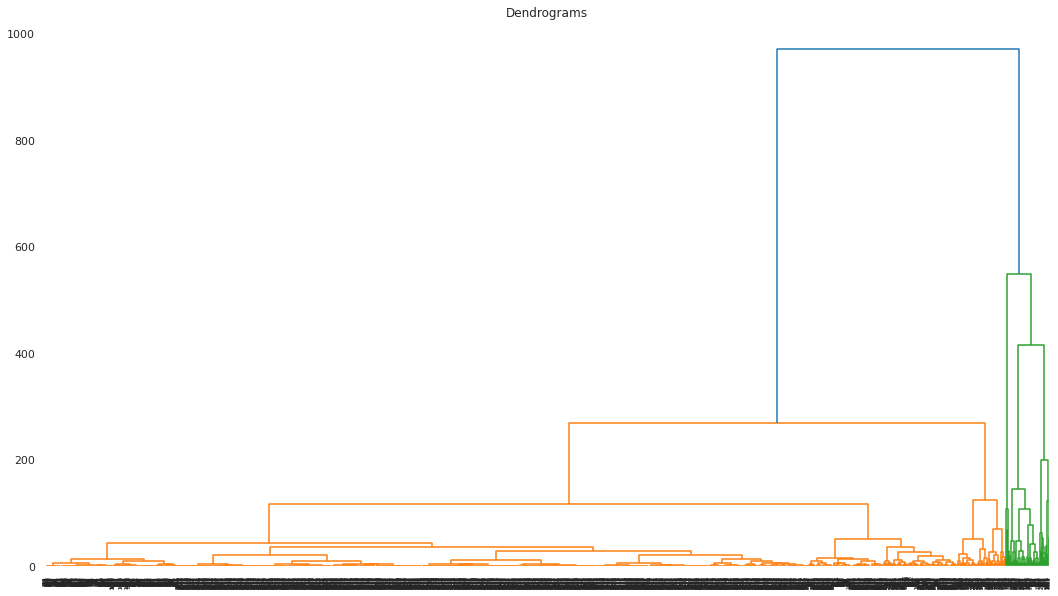

In [ ]:
# Take a while to run

plt.figure(figsize=(18, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

Based on the dendograms above, it seems that the optimal number of clusters is 2 but it will be hard for us to interpret the label with only 2 clusters so we're going to use 4 instead

## Training the Model

## Train Using BIRCH

In [ ]:
def train(X):
  birch = Birch(n_clusters=4)

  model = birch.fit(X)

  y_hat = model.predict(X)

  print("Silhouette Coefficient: %0.3f" % silhouette_score(X,y_hat))
  print("Calinski Harabasz: %0.3f" % calinski_harabasz_score(X,y_hat))

  df_clustered['Cluster'] = y_hat

  return model

Train and save the clustering result to the clustered dataframe

In [ ]:
model = train(X)

Silhouette Coefficient: 0.885
Calinski Harabasz: 6373.324


# Cluster Visualization

## PCA

In [ ]:
pca = PCA(n_components=2).fit_transform(X)

df_clustered['PCA1'] = pca[:, 0]
df_clustered['PCA2'] = pca[:, 1]

df_clustered.head()

,Jenis Usaha,Provinsi,Jenis Ikan,Tahun,Volume Produksi,Nilai Produksi,Cluster,PCA1,PCA2
0,BUDIDAYA,BANTEN,BANDENG,2010,11071.00,82781877.0,1,-0.884120,-1.127025
1,BUDIDAYA,BANTEN,BANDENG,2011,9542.74,124055620.0,1,-0.890513,-0.484778
2,BUDIDAYA,BANTEN,BANDENG,2012,8739.46,239161200.0,1,-0.208043,0.798159
3,BUDIDAYA,BANTEN,BANDENG,2013,10997.10,171425024.0,1,-0.248260,-0.219063
4,BUDIDAYA,BANTEN,BANDENG,2014,11141.62,174132000.0,1,-0.199125,-0.212901


Use PCA to help visualize the clusters

In [ ]:
def visualize(df):
  fig, ax = plt.subplots(1, 1, figsize=(12,8))
  sns.scatterplot(x='PCA1', y='PCA2', data=df, hue='Cluster', ax=ax).set_title(
      'Cluster Result', fontsize=18, fontweight='bold')

  plt.tight_layout()
  plt.show();

## Cluster Result

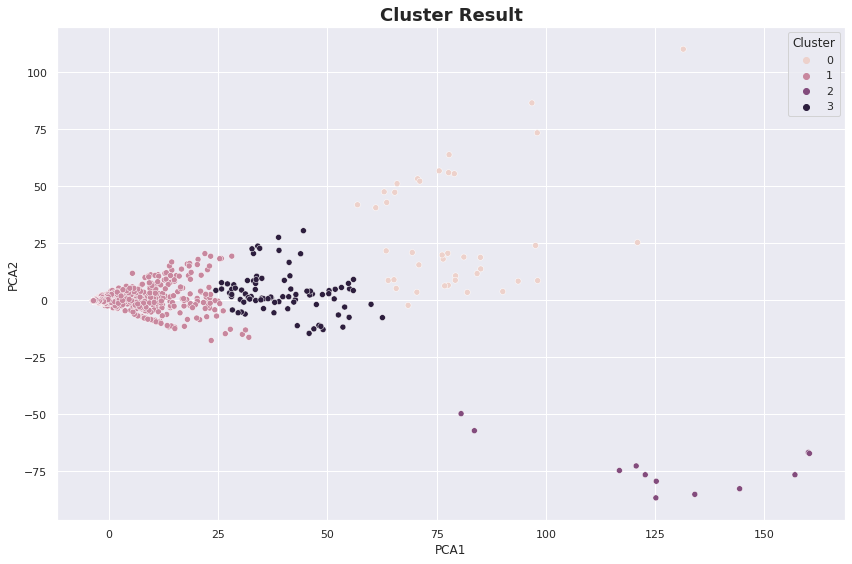

In [ ]:
visualize(df_clustered)

Just as we expected there are outliers in our cluster. The distance between Cluster 1 and 3 is close so they might have some similarity. Some of Cluster 0 and 3 are close. Cluster 2 distance is far from the other clusters

# Finalizing Model

## Save

In [ ]:
def finalize_model(mdl):
  with open('birch.pkl', 'wb') as b:
    pickle.dump(mdl, b)

Save the model using pickle to use it later

## Load

In [ ]:
def load_model():
  with open('birch.pkl', 'rb') as b:
    model = pickle.load(b)
    print(model)

    return model

Load the saved model

In [ ]:
finalize_model(model)

In [ ]:
loaded_model = load_model()

Birch(n_clusters=4)


# Post Processing

## Interpret By Volume and Nilai of Jenis Usaha

In [ ]:
volume_by_usaha = df_clustered.groupby(['Jenis Usaha', 'Cluster'])['Volume Produksi'].mean().unstack()

volume_by_usaha

Cluster,0,1,2,3
Jenis Usaha,,,,
BUDIDAYA,194217.839722,11446.492448,595463.613333,123980.172031
TANGKAP LAUT,218673.797500,5142.370987,NaN,159357.127500
TANGKAP PUD,NaN,609.714356,NaN,NaN


In [ ]:
nilai_by_usaha = df_clustered.groupby(['Jenis Usaha', 'Cluster'])['Nilai Produksi'].mean().unstack()

nilai_by_usaha

Cluster,0,1,2,3
Jenis Usaha,,,,
BUDIDAYA,5.914041e+09,1.834464e+08,1.464306e+09,2.356957e+09
TANGKAP LAUT,4.993527e+09,1.061221e+08,NaN,1.976858e+09
TANGKAP PUD,NaN,9.685308e+06,NaN,NaN


- Cluster 0 produced BUDIDAYA and TANGKAP LAUT and generated most  of Volume and Nilai
- Cluster 1 produced from all Jenis Usaha but generated only a little Volume and Nilai
- Cluster 2 only produced from BUDIDAYA and generated high amount of Volume but only decent amount of Nilai
- Cluster 3 produced from BUDIDAYA and TANGKAP LAUT and produced a decent amount of Volume and Nilai


## Inrerpet By Volume and Nilai of Jenis Ikan

In [ ]:
volume_by_ikan = df_clustered.groupby(['Jenis Ikan', 'Cluster'])['Volume Produksi'].mean().unstack()

In [ ]:
nilai_by_ikan = df_clustered.groupby(['Jenis Ikan', 'Cluster'])['Nilai Produksi'].mean().unstack()

In [ ]:
filter_volume_ikan = volume_by_ikan[(volume_by_ikan[0] > 4000) | 
                                    (volume_by_ikan[1] > 4000) | 
                                    (volume_by_ikan[2] > 4000) | 
                                    (volume_by_ikan[3] > 4000) ]

In [ ]:
filter_nilai_ikan = nilai_by_ikan[(nilai_by_ikan[0] > 7.997198e+07) | 
                                  (nilai_by_ikan[1] > 7.997198e+07) | 
                                  (nilai_by_ikan[2] > 7.997198e+07) | 
                                  (nilai_by_ikan[3] > 7.997198e+07) ]

Because Jenis Ikan have a lot of unique value, we're going to only show the ones with average Volume and Nilai > Q3(75%)

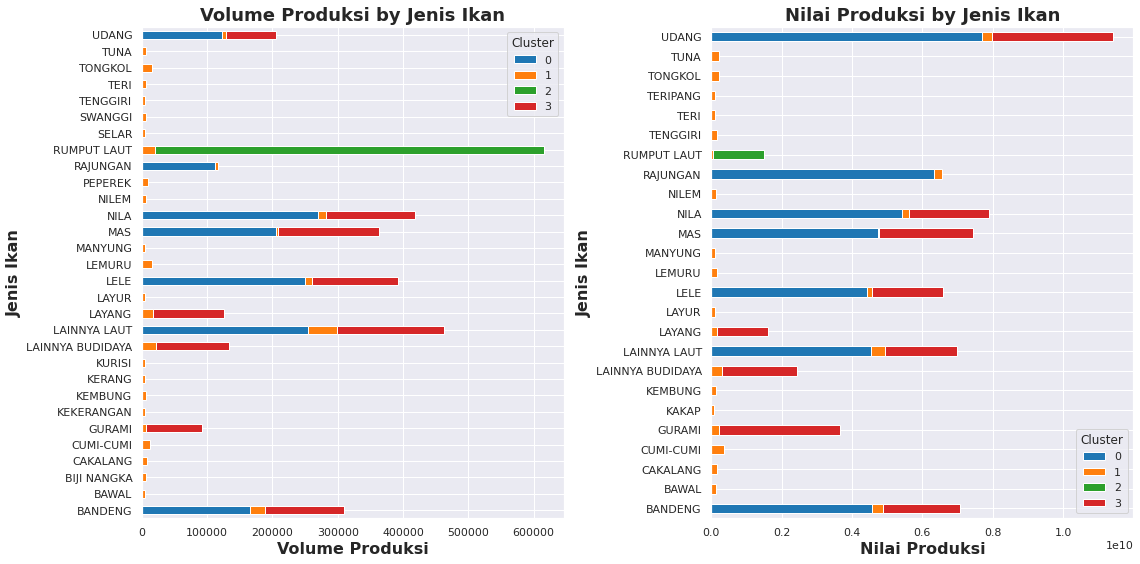

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))

filter_volume_ikan.plot(kind='barh', stacked=True, ax = axs[0])
axs[0].set_title('Volume Produksi by Jenis Ikan', fontsize=18, fontweight='bold')
axs[0].set_ylabel('Jenis Ikan', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Volume Produksi', fontsize=16, fontweight='bold')

filter_nilai_ikan.plot(kind='barh', stacked=True, ax = axs[1])
axs[1].set_title('Nilai Produksi by Jenis Ikan', fontsize=18, fontweight='bold')
axs[1].set_ylabel('Jenis Ikan', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Nilai Produksi', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

- Cluster 0 produced most of Jenis Ikan from Budidaya but also produced a lot of LAINNYA LAUT and produced a lot of Volume and Nilai
- Cluster 1 produced most if not all of Jenis Ikan but only produced a little Volume and Nilai
- Cluster 2 only produced RUMPUT LAUT but produced a lot of it although the Nilai isn't that much compared to it's Volume 
- Cluster 3 produced a variety of Jenis Ikan and made a decent amount of Volume and Nilai


## Conclusion For Labeling

Based on our interpretations above, we can conclude that:
- Cluster 0 can be labeled as 'Potential Fish Production'
- Cluster 1 can be labeled as 'High Variety Low Production'
- Cluster 2 can be labeled as 'Potential Rumput Laut Production'
- Cluster 3 can be labeled as 'Decent Fish Production'

## Labeling

In [ ]:
labels_og = [0, 1, 2, 3]
labels_final = ['Potential Fish Production', 'High Variety Low Production',
                'Potential Rumput Laut Production', 'Decent Fish Production']
map_dict = dict(zip(labels_og, labels_final))

df_labeled = df_clustered.copy()
df_labeled.drop(columns=['PCA1', 'PCA2'], inplace=True)

df_labeled['Cluster'] = df_labeled['Cluster'].map(map_dict)

In [ ]:
df_labeled.sample(10)

,Jenis Usaha,Provinsi,Jenis Ikan,Tahun,Volume Produksi,Nilai Produksi,Cluster
2686,TANGKAP LAUT,JAWA TIMUR,BAWAL,2015,9215.00,1.581304e+08,High Variety Low Production
546,BUDIDAYA,JAWA BARAT,LAINNYA BUDIDAYA,2013,90092.04,1.106689e+09,High Variety Low Production
1000,BUDIDAYA,JAWA TIMUR,RUMPUT LAUT,2020,699235.92,2.614811e+09,Potential Rumput Laut Production
1694,TANGKAP LAUT,DKI JAKARTA,BIJI NANGKA,2020,96.36,1.002645e+06,High Variety Low Production
2248,TANGKAP LAUT,JAWA BARAT,SUNGLIR,2021,581.75,1.163935e+07,High Variety Low Production
643,BUDIDAYA,JAWA BARAT,UDANG,2021,178199.85,1.350065e+10,Potential Fish Production
2869,TANGKAP LAUT,JAWA TIMUR,MAKEREL,2021,52.94,1.223674e+06,High Variety Low Production
3751,TANGKAP PUD,JAWA TENGAH,BELIDA,2020,46.42,6.962250e+02,High Variety Low Production
2111,TANGKAP LAUT,JAWA BARAT,KERONG-KERONG,2020,0.08,7.500000e+02,High Variety Low Production
1078,TANGKAP LAUT,BANTEN,CUCUT,2014,1037.00,1.201801e+07,High Variety Low Production
